# Multimodal Prediction using TabularPredictor

본 핸즈온에서는 TabularPredictor로 multimodal 데이터를 훈련합니다.

## TextPredictor & TabularPredictor

TextPredictor로도 multimodal 데이터의 훈련이 가능하지만, 만약 XGBoost/LightGBM/CatBoost 등의 Gradient Boosted Tree 알고리즘을 앙상블 및 스태킹하여 모델링하고 싶다면, `TabularPredictor.fit (..., hyperparameters = 'multimodal')`로 훈련할 수도 있습니다. `hyperparameters = 'multimodal'`을 지정하지 않고 훈련 시, AutoGluon Tabular는 텍스트 데이터를 N-gram으로 자동으로 변환 후 tabular 모델만 훈련합니다. 


In [1]:
# GPU 인스턴스를 사용하시면 아래 주석을 해제하고 본 코드 셀을 실행해 주세요.
# !pip install --upgrade mxnet-cu100

In [2]:
import os
import mxnet as mx
num_gpus = mx.context.num_gpus()

if num_gpus == 0:
    os.environ['AUTOGLUON_TEXT_TRAIN_WITHOUT_GPU'] = '1'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import random
from autogluon.tabular import TabularPredictor
import mxnet as mx

np.random.seed(123)
random.seed(123)
mx.random.seed(123)

## 1. Data preparation and Training

본 핸즈온은 MachineHack Salary Prediction Hackathon의 제품 리뷰 데이터셋을 사용합니다. 리뷰 점수는 0,1,2,3점의 4개 클래스로 구성되어 있는 다중 클래스 문제입니다.

In [4]:
save_path = 'ag-04-multimodal-tabularpredictor'
!rm -rf $save_path product_sentiment

In [5]:
!mkdir -p product_sentiment
!wget https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/train.csv -O product_sentiment/train.csv
!wget https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/dev.csv -O product_sentiment/dev.csv
!wget https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/test.csv -O product_sentiment/test.csv

--2021-04-03 10:24:44--  https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/train.csv
Resolving autogluon-text-data.s3.amazonaws.com (autogluon-text-data.s3.amazonaws.com)... 52.217.192.121
Connecting to autogluon-text-data.s3.amazonaws.com (autogluon-text-data.s3.amazonaws.com)|52.217.192.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689486 (673K) [text/csv]
Saving to: ‘product_sentiment/train.csv’

product_sentiment/t 100%[===================>] 673.33K   641KB/s    in 1.1s    

2021-04-03 10:24:46 (641 KB/s) - ‘product_sentiment/train.csv’ saved [689486/689486]

--2021-04-03 10:24:46--  https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/dev.csv
Resolving autogluon-text-data.s3.amazonaws.com (autogluon-text-data.s3.amazonaws.com)... 52.217.192.121
Connecting to autogluon-text-data.s3.amazonaws.com (autogluon-text-data.s3.amazonaws.com)|52.217.192.121|:443... connected.
HTT

In [6]:
subsample_size = 1000  # for quick demo, try setting to larger values
feature_columns = ['Product_Description', 'Product_Type']
label = 'Sentiment'

train_df = pd.read_csv('product_sentiment/train.csv', index_col=0).sample(subsample_size, random_state=123)
dev_df = pd.read_csv('product_sentiment/dev.csv', index_col=0)
test_df = pd.read_csv('product_sentiment/test.csv', index_col=0)

train_df = train_df[feature_columns + [label]]
dev_df = dev_df[feature_columns + [label]]
test_df = test_df[feature_columns]
print('Number of training samples:', len(train_df))
print('Number of dev samples:', len(dev_df))
print('Number of test samples:', len(test_df))

Number of training samples: 1000
Number of dev samples: 637
Number of test samples: 2728


In [7]:
train_df.head(5)

,Product_Description,Product_Type,Sentiment
4532,they took away the lego pit but replaced it wi...,0,1
1831,#Apple to Open Pop-Up Shop at #SXSW [REPORT]: ...,9,2
3536,RT @mention False Alarm: Google Circles Not Co...,5,1
5157,Will Google reveal a new social network called...,9,2
4643,Niceness RT @mention Less than 2 hours until w...,6,3


Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "ag-04-multimodal-tabularpredictor/"
AutoGluon Version:  0.1.0
Train Data Rows:    1000
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	4 unique label values:  [1, 2, 3, 0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
NumExpr defaulting to 4 threads.
Train Data Class Count: 4
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    60817.5 MB
	Train Data (Original)  Memory Usage: 0.17 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Ge

All Logs will be saved to /home/ec2-user/SageMaker/autogluon-on-aws/2.nlp/ag-04-multimodal-tabularpredictor/models/TextNeuralNetwork/task0/training.log


[Iter 2/70, Epoch 0] valid accuracy=6.2000e-01, log_loss=8.5257e-01, accuracy=6.2000e-01, time spent=1.544s, total time spent=0.17min. Find new best=True, Find new top-3=True
[Iter 4/70, Epoch 0] valid accuracy=8.6000e-01, log_loss=6.9343e-01, accuracy=8.6000e-01, time spent=1.520s, total time spent=0.38min. Find new best=True, Find new top-3=True
[Iter 6/70, Epoch 0] valid accuracy=8.6000e-01, log_loss=5.7728e-01, accuracy=8.6000e-01, time spent=1.523s, total time spent=0.59min. Find new best=True, Find new top-3=True
[Iter 8/70, Epoch 1] valid accuracy=8.6000e-01, log_loss=5.4352e-01, accuracy=8.6000e-01, time spent=1.533s, total time spent=0.87min. Find new best=True, Find new top-3=True


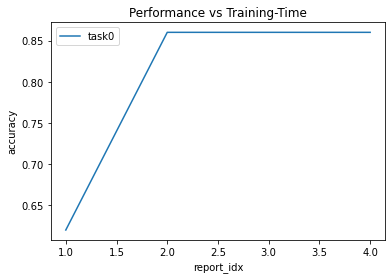

	0.86	 = Validation accuracy score
	66.56s	 = Training runtime
	2.16s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 58.86s of the -24.79s of remaining time.
	0.865	 = Validation accuracy score
	0.31s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 85.65s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("ag-04-multimodal-tabularpredictor/")


In [8]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label='Sentiment', path=save_path)
predictor.fit(train_df, hyperparameters='multimodal', time_limit=60)

<br>

## 2. Evaluation and Prediction

In [9]:
predictor.leaderboard(dev_df)

                 model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             CatBoost    0.886970      0.860        0.012034       0.011266   0.735564                 0.012034                0.011266           0.735564            1       True          4
1    TextNeuralNetwork    0.886970      0.860        7.719705       2.160841  66.564482                 7.719705                2.160841          66.564482            1       True          7
2       NeuralNetMXNet    0.885400      0.865        0.189090       0.120658   2.912311                 0.189090                0.120658           2.912311            1       True          1
3  WeightedEnsemble_L2    0.885400      0.865        0.201551       0.121253   3.226868                 0.012461                0.000595           0.314557            2       True          8
4             LightGBM    0.879121      0.855

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.886970,0.860,0.012034,0.011266,0.735564,0.012034,0.011266,0.735564,1,True,4
1,TextNeuralNetwork,0.886970,0.860,7.719705,2.160841,66.564482,7.719705,2.160841,66.564482,1,True,7
2,NeuralNetMXNet,0.885400,0.865,0.189090,0.120658,2.912311,0.189090,0.120658,2.912311,1,True,1
3,WeightedEnsemble_L2,0.885400,0.865,0.201551,0.121253,3.226868,0.012461,0.000595,0.314557,2,True,8
4,LightGBM,0.879121,0.855,0.008870,0.005189,1.076315,0.008870,0.005189,1.076315,1,True,2
5,XGBoost,0.877551,0.850,0.095386,0.006455,0.849035,0.095386,0.006455,0.849035,1,True,5
6,LightGBMLarge,0.864992,0.845,0.029430,0.006510,2.138445,0.029430,0.006510,2.138445,1,True,6
7,LightGBMXT,0.854003,0.845,0.046312,0.008461,0.828814,0.046312,0.008461,0.828814,1,True,3


In [10]:
score = predictor.evaluate(dev_df)
print(score)

Predictive performance on given data: accuracy = 0.8854003139717426
0.8854003139717426
